## Background

In this notebook I'll run some experiments to compare random numbers generated with the following approaches:

- The [Australian National University Quantum Numbers API](https://quantumnumbers.anu.edu.au/documentation)
- `random` (Python Standard Library)
- `numpy.random.randint`
- `torch.randint`
- The `rand` function from Lesson 10 of the fastai course (Part 2)

## Getting ~100k Random Numbers from the ANU API

I refactored [code from the ANU documentation](https://gist.github.com/cqtsma2/27af54ffddd6ababd114d9f642517611) into the following function:

In [56]:
import json, requests, random
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from scipy import stats

In [26]:
def get_anu(qrn_key, dtype, length, blocksize=1):
  QRN_URL = "https://api.quantumnumbers.anu.edu.au/"
  params = {"length": length, "type": dtype, "size": blocksize}
  headers = {"x-api-key": qrn_key}

  response = requests.get(QRN_URL, headers=headers, params=params)

  if response.status_code == 200:
    js = response.json()
    if js["success"] == True:
        print(js["data"])
    else:
        print(js["message"])
  else:
    print(f"Got an unexpected status-code: {response.status_code}")
    print(response.text)

So that I could run through a loop for multiple API calls. I ended up using 3 calls for testing so only generated 99328 total random numbers (1024 per 97 API calls).

In [ ]:
results = []

for i in range(100):
  res = get_anu(qrn_key=QRN_KEY, dtype="uint8", length=1024, blocksize=1)
  results.extend(res)

In [7]:
len(results)

99328

I have uploaded the list of random numbers to [this gist](https://gist.githubusercontent.com/vishalbakshi/9f1a3cc7611b1609fd447a75a3165b98/raw/21529dc2e9a82564be2275d3039ead353a3d95d4/anu_api_random_numbers.txt). You can use the following helper function to load the txt file into a python list:

```python
# Loading the list from a file
def load_list(file_name):
    with open(file_name, 'r') as file:
        return json.load(file)
        
# Load the list
results = load_list("anu_random_numbers.txt")
```

## Viewing the Random Numbers

Let's take a moment and appreciate the beauty of truly random numbers! It looks like static on an old TV screen:

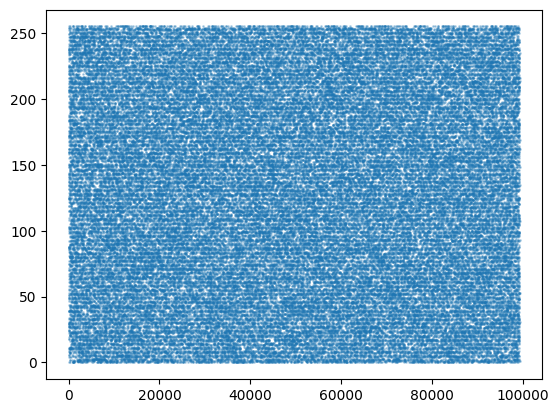

In [28]:
results = pd.Series(results)
plt.scatter(results.index, results.values, s=1, alpha=0.3);

## Generating Random Numbers Using Other Approaches

I'll now generate 99,328 random numbers using the following methods:

- `random` (Python Standard Library)
- `numpy.random.randint`
- `torch.randint`
- The `rand` function from Lesson 10 of the fastai course (Part 2)

Note that the ANU random numbers are between 0-255.

> the data type must be `'uint8'` (returns integers between 0-255)

In [29]:
results.min(), results.max()

(0, 255)

### `random` (Python Standard Library)

From the Python docs:

> `random.randint(a, b)`
>
> Return a random integer N such that a <= N <= b. Alias for randrange(a, b+1).

In [33]:
random.randint(0,255)

134

In [35]:
py_results = pd.Series([random.randint(0,255) for _ in range(99328)])
py_results.min(), py_results.max()

(0, 255)

Visibly, there's not much difference between this scatter plot and the ANU random numbers.

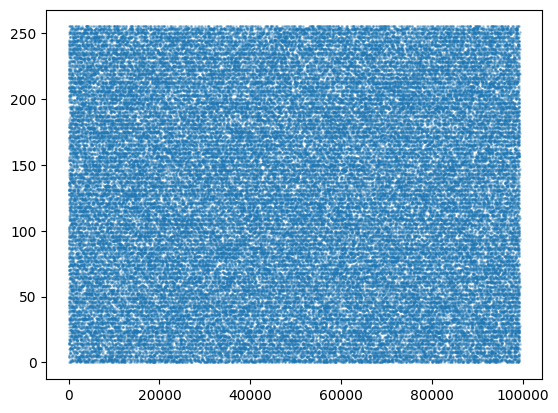

In [36]:
plt.scatter(py_results.index, py_results.values, s=1, alpha=0.3);

### `numpy.random.randint`

The NumPy functionality is a bit different, it _excludes_ the upper bound that you provide:

> Return random integers from low (inclusive) to high (exclusive).

In [41]:
np.random.randint(0, 256)

236

In [42]:
np_results = pd.Series([np.random.randint(0, 256) for _ in range(99328)])
np_results.min(), np_results.max()

(0, 255)

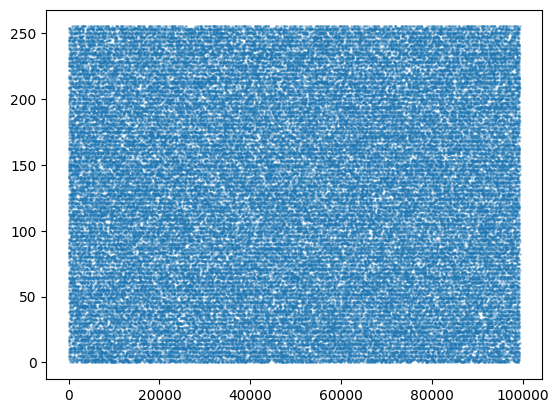

In [43]:
plt.scatter(np_results.index, np_results.values, s=1, alpha=0.3);

### `torch.randint`

PyTorch does it similar to NumPy:

> Returns a tensor filled with random integers generated uniformly between low (inclusive) and high (exclusive).

But also asks the shape of the tensor you want as a parameter.

In [47]:
pt_results = pd.Series(torch.randint(0, 256, (99328,)))
pt_results.shape, pt_results.min(), pt_results.max()

((99328,), 0, 255)

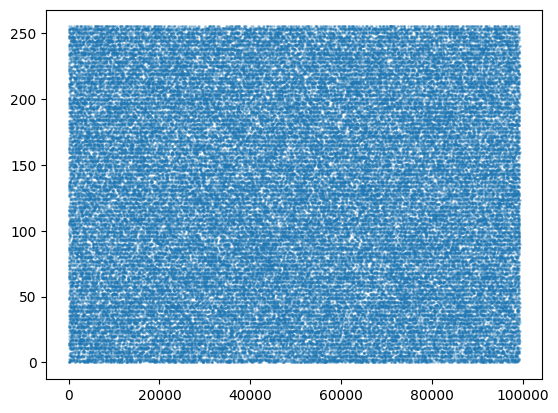

In [48]:
plt.scatter(pt_results.index, pt_results.values, s=1, alpha=0.3);

### Custom `rand` Implementation

In [Lesson 10](https://youtu.be/6StU6UtZEbU?feature=shared&t=5819) of the fastai course (Part 2), Jeremy implements the following from-scratch random number generator:

In [49]:
rnd_state = None
def seed(a):
    global rnd_state
    a, x = divmod(a, 30268)
    a, y = divmod(a, 30306)
    a, z = divmod(a, 30322)
    rnd_state = int(x)+1, int(y)+1, int(z)+1

In [50]:
seed(457428938475)
rnd_state

(4976, 20238, 499)

In [51]:
def rand():
    global rnd_state
    x, y, z = rnd_state
    x = (171 * x) % 30269
    y = (172 * y) % 30307
    z = (170 * z) % 30323
    rnd_state = x,y,z
    return (x/30269 + y/30307 + z/30323) % 1.0

In [52]:
rand()

0.7645251082582081

Since this implementation generates floats between 0 and 1, I'll have to handle it a bit differently:

In [53]:
rand_results = pd.Series([int(rand()*256) for _ in range(99328)])
rand_results.min(), rand_results.max()

(0, 255)

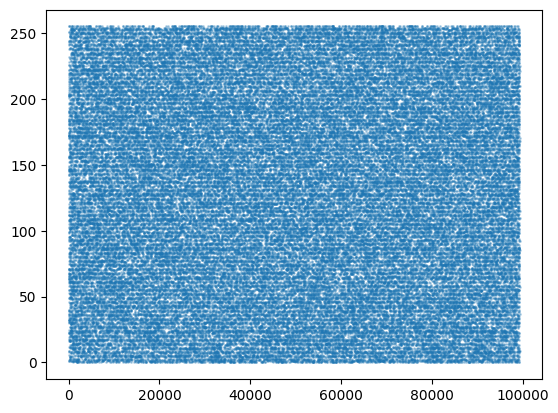

In [54]:
plt.scatter(rand_results.index, rand_results.values, s=1, alpha=0.3);

## Comparing Random Numbers Generated with Different Methods

Upon visual inspection, the distributions of 99328 random numbers generated by the different methods look similar.

With the help of Claude, I'll apply a few statistical tests and compare the results across all five sets of (differently generated) random integers:

In [77]:
def random_analysis(data_sets, names):
    results = []

    # Create a 2x3 grid of subplots
    fig, axs = plt.subplots(2, 3, figsize=(10, 5))
    axs = axs.flatten()

    for i, (data, name) in enumerate(zip(data_sets, names)):
        # Basic statistical measures
        mean = np.mean(data)
        variance = np.var(data)
        std_dev = np.std(data)

        # Chi-square test for uniformity
        observed_freq, _ = np.histogram(data, bins=256, range=(0, 255))
        expected_freq = len(data) / 256  # Assuming uniform distribution
        chi2_stat, chi2_p = stats.chisquare(observed_freq, f_exp=[expected_freq]*256)

        # Kolmogorov-Smirnov test
        ks_stat, ks_p = stats.kstest(data, 'uniform', args=(0, 256))

        results.append({
            'Name': name,
            'Mean': mean,
            'Variance': variance,
            'Std Dev': std_dev,
            'Chi-square Statistic': chi2_stat,
            'Chi-square p-value': chi2_p,
            'KS Statistic': ks_stat,
            'KS p-value': ks_p
        })

        # Plot histogram in the corresponding subplot
        axs[i].hist(data, bins=256, range=(0, 255), density=True)
        axs[i].set_title(f'Histogram for {name}')
        axs[i].set_xlabel('Value')
        axs[i].set_ylabel('Frequency')

    # Remove any unused subplots
    for j in range(i+1, len(axs)):
        fig.delaxes(axs[j])

    plt.tight_layout()
    plt.show()

    return pd.DataFrame(results)

Again, by visual inspection, the histograms of the differently generated random integers look similar, if not the same. It's interesting to note that there _are_ dips in the distribution where certain integers have significantly lower occurences than others.

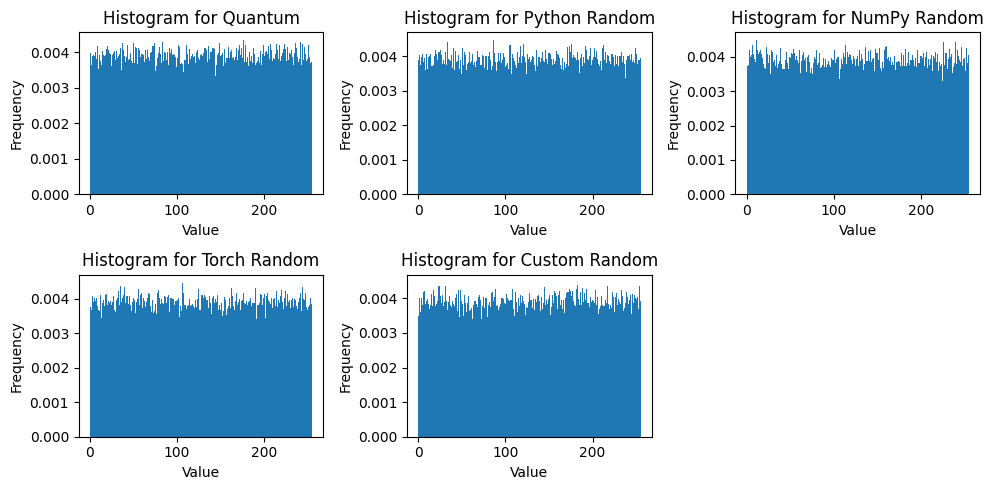

In [78]:
data_sets = [results, py_results, np_results, pt_results, rand_results]
names = ['Quantum', 'Python Random', 'NumPy Random', 'Torch Random', 'Custom Random']

res = random_analysis(data_sets, names)

Next, I'll interpret the various statistics calculated.

For a uniform distribution (between $a=0$ and $b=255$), the expected value for the mean, variance and standard deviation are as follows:




$$\text{Mean: }  \mu = \frac{a + b}{2} = \frac{0 + 255}{2} = 127.5$$

<br>


$$\text{Var: }  \sigma^2 = \frac{(b - a + 1)^2 - 1}{12} =  \frac{(255 - 0 + 1)^2 - 1}{12} = \frac{256^2 - 1}{12} \approx 5461.25$$

<br>

$$\text{Std: } \sigma = \sqrt{5461.25} \approx 73.91$$

The method with the mean closest to the expected value is `numpy.random.randint` (127.502). The closest variance to the expected value is the ANU Quantum method (5459.429).The closes standard deviation is also the ANU Quantum method (73.888).

In [79]:
res

,Name,Mean,Variance,Std Dev,Chi-square Statistic,Chi-square p-value,KS Statistic,KS p-value
0,Quantum,127.584518,5459.429128,73.887950,216.123711,0.963092,0.004792,0.020812
1,Python Random,127.677402,5451.449199,73.833930,246.185567,0.642552,0.004651,0.027113
2,NumPy Random,127.502638,5482.749449,74.045590,277.453608,0.159672,0.006041,0.001416
3,Torch Random,127.531039,5477.553241,74.010494,237.572165,0.776473,0.005477,0.005147
4,Custom Random,127.894380,5469.084638,73.953260,289.896907,0.065635,0.004671,0.026121


Next, I'll look at the chi-square statistic, where lower values are better. The Quantum method has the lowest chi-square statistic with the highest p-value, meaning it's the closest to a uniform distribution.

Next, looking at the KS statistic, from the SciPy docs, it measures:

> the distance between the empirical distribution function and the hypothesized cumulative distribution function

Again, lower values are better. However, the p-values are all lower than 0.05, indicating that the null hypothesis (that the data comes from a uniform distribution) should be rejected. Claude provided the following insight:

> The KS test is very sensitive, especially with large sample sizes. With 99,328 numbers, even small deviations from perfect uniformity can lead to statistically significant results.

My interpretation of this is that it's not a perfectly uniform distribution.

## Reducing the Number of Samples

I'll run these tests with a much lower number of samples and see if that changes any of the statistics significantly.

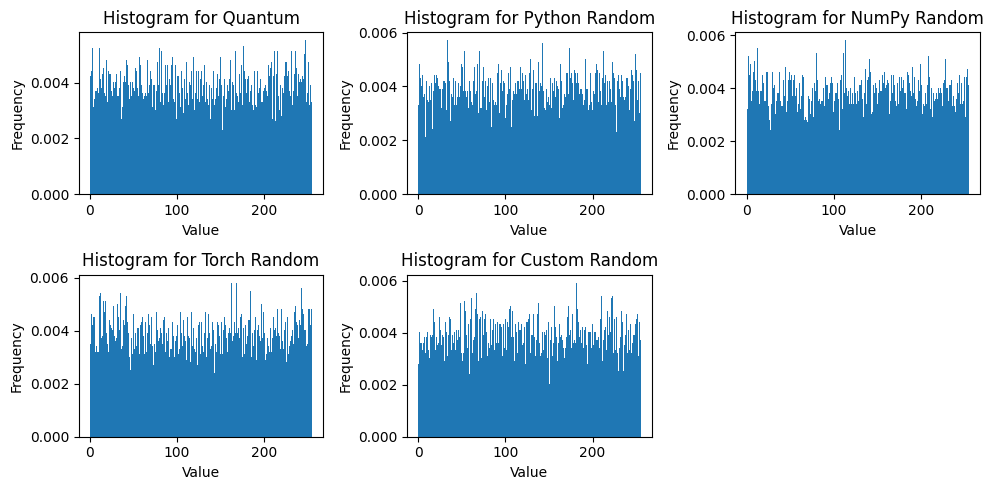

In [80]:
data_sets = [results[:10000], py_results[:10000], np_results[:10000], pt_results[:10000], rand_results[:10000]]
names = ['Quantum', 'Python Random', 'NumPy Random', 'Torch Random', 'Custom Random']

res = random_analysis(data_sets, names)

Using only 10,000 samples each, the statistics have changed:

- The Quantum method no longer has the variance closest to the expected value of 5461.25. That claim belongs to Python's `random` module (which has the closest value, 73.9 to the expected standard deviation of 73.91).
- NumPy again has the closet mean to the expected value of 127.5.
- The Chi-square statistics have changed, with Python leading the way (although all of the methods still have a high p-value).
- The KS statistic has also significantly changed: all methods now have a p-value greater than 0.05, indicating that the null hypothesis (that they belong to a uniform distribution) cannot be rejected.

In [81]:
res

,Name,Mean,Variance,Std Dev,Chi-square Statistic,Chi-square p-value,KS Statistic,KS p-value
0,Quantum,127.6421,5556.331208,74.540802,236.6720,0.788774,0.008306,0.492614
1,Python Random,128.3820,5461.679276,73.903175,234.7264,0.814062,0.007994,0.542459
2,NumPy Random,127.5575,5459.439094,73.888017,236.2112,0.794925,0.009550,0.319373
3,Torch Random,127.9056,5668.028889,75.286313,265.1392,0.318255,0.015931,0.012354
4,Custom Random,127.8054,5392.456331,73.433346,276.6592,0.167893,0.008838,0.413184


## Final Thoughts

I was surprised that the random numbers generated by alternative approaches to the ANU Quantum generated were comparable to it! I was also surprised that even the Quantum-generated random numbers were not perfect---they still deviated from the expected values of a uniform distribution. I was also not expecting the statistics to change so dramatically depending on the number of samples analyzed.

This is my first true foray into the world of random number generation (outside of setting seeds during training) and I have probably only scratched the surface. I look forward to being more mindful about random numbers in the future.

Thanks for reading this blog post! Follow me on Twitter [@vishal_learner](https://twitter.com/vishal_learner).